# Usage Demonstration Notebook

In this notebook we demonstrate the usage of our neuron and network classes, calculating and visualizing the dynamics of a single neuron and a simple network.  The preamble to set up this notebook is below, note that ``Network`` and ``Neuron`` are imported.

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from neuron import Neuron
from network import Network
from IPython.display import HTML

# Usage of Neuron Class

We first study the dynamics of the "Yamada" Laser neuron model, which describes a two section laser containing a gain region and a saturable absorber.  Input optical signals stimulate a photodiode, which controls the current into the gain region.  The equations of motion are:
\begin{equation} \dot{I}=\kappa(1-G-Q)I+\beta \\ \dot{G}=\gamma(A+i_{in}(t)-G-IG) \\ \dot{Q}=\gamma(B-Q-aIQ) \end{equation}
Where $I$ is the dimensionless laser intensity, and $G$ and $Q$ are the inversions of the gain and saturable absorbing media.  $i_{in}$ sufficient to produce $G+Q>1$ results in a sharp laser pulse and the system then refracts.  For excitability, we require $\gamma\ll\kappa$: the field intensity is our fast "state" variable and the inversions are slow "recovery" variables, like the membrane potential and ion permeability respectively in biological neurons.  

We begin by choosing our model parameters, contained in the dict ```Y1mpars``` below, and then the parameters for the neuron itself, ```Y1params```.  The equations of motion above are contained in ```models.Yamada_1```, so we specify this, as well as ```mpars``` and the timestep ```dt```.  It is important that we initialize our neuron in its steady state, so we use the neuron member function ```steady_state``` to compute the steady state for our specific choice of model parameters.  To be successful, this requires an initial guess of the steady state, which is ```y1_steady_est```.  We then update the full set of parameters ```Y1params``` for the Neuron object we will be creating.

In [7]:
#basic setup stuff
#Create a basic Yamada Neuron 
Y1mpars={"a": 2, "A": 6.5, "B":-6., "gamma1": 1,
         "gamma2": 1, "kappa": 50, "beta": 5e-1 }#these are the model parameters

Y1params={"model" : "Yamada_1","dt": 1e-2, 'mpar': Y1mpars} #neuron parameters

y1_steady_est=[Y1mpars['beta']/Y1mpars['kappa'],
               Y1mpars['A'],Y1mpars['B'] ] #quick estimate of ss

y1_steady=Neuron(Y1params).steady_state(y1_steady_est) #compute true steady state

Y1params["y0"]=y1_steady #change model parameters so that starts w this ss

#now just use Y1params to initialize neurons

We now proceed to initialize a Neuron with ```neuron_object=Neuron(neuron_parameters)```.  We then construct an input signal ```x1``` which is a series of Gaussian inputs, the first of which is below threshold and will not cause the neuron to spike, and the last is very noisy but will.  The Neuron dynamics are then computed with ```output=neuron_object.solve(input)``` 

In [9]:
#initialize neuron
Y1Neuron=Neuron(Y1params)

#create time signal
t1_end=8. #final time point
N1=int(np.ceil(t1_end/Y1Neuron.dt)) #this many points
time1=np.linspace(0.,(N1-1)*Y1Neuron.dt, num=N1 )

#normalized guassian for constructing input signals
Gaussian_pulse= lambda x, mu, sig: np.exp(-np.power(x - mu, 2.) 
    / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)
#create input signal x1
x1=np.zeros(N1)
x1+=0.2*Gaussian_pulse(time1, 0.1, 5.e-2)
x1+=0.4*Gaussian_pulse(time1, 2., 5.e-2)
x1+=0.4*Gaussian_pulse(time1, 6.5, 5.e-2)*np.random.normal(1, 1,N1)

#solve
y_out1=Y1Neuron.solve(x1)

These results are visualized with ```figure=neuron_object.visualize_plot(input, output, time, steady_state)```.  

The upper axis contains the input current to the neuron, and the lower is the resultant dynamics.  The light intensity is the left axis in blue and the gain and absorber inversions are in red and green on the right axis.  The steady states are also indicated with dashed lines.  Note that a spike is not seen for the initial Gaussian input pulse, as its area is below threshold.  The second and third pulses have the same area and thus produce nearly identical responses, even though the later is quite noisy.  The refractory period can also be seen as the large time it takes for the inversion variables to recover after each spike.

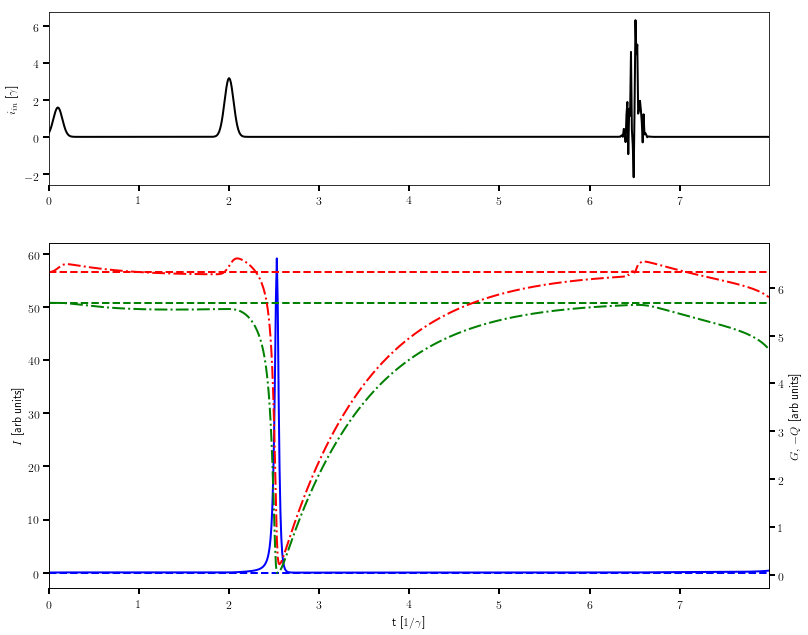

In [11]:
fig1=Y1Neuron.visualize_plot(x1, y_out1, time1, y1_steady)
#can use returned figure object to customize plot, as below
fig1.set_size_inches(10, 8, forward=True)

# Usage of Network Class

We next consider an inhibitory network of two neurons, each with their own input channel.  Neuron 2 is inhibitively connected to neuron 1:  when it fires it prevents Neuron 1 from firing.  

These simple networks often govern reflex behaviors such as the knee-jerk:  When the knee is tapped, the patellar sensory neuron fires, this inhibits a motor neuron controlling the flexor hamstring muscle, causing it to relax and allowing your leg to kick out.


We first construct a list of 2 identical neurons (```neurons=[Neuron(Y1params), Neuron(Y1params)]```)
, then our weight and delay matrices (```weights=np.array(...)```, ```delays=np.array(...)```)
, and use these to create a network: ```network=Network(neurons, weights, delays)```
.  This network is driven by a series of pulses defined as a time-dependent external input array, and its dynamics are calculated with ```output=network.network_solve(input)```.  The Network class also has a member function which computes the total time-dependent input (sum of internal and external) to each neuron, to better understand and visualize the network dynamics, this is done via ```total_input=network.network_inputs(output, input)```.  Note that the external inputs are the second argument.

Examples of the structures of the weights and delay matrices are shown XXXX


In [14]:
# Inhibitory 2 input 2 neuron network
#neuron 1 is regularly firing, neuron 2 stops neuron 1 from firing 

neurons=[Neuron(Y1params), Neuron(Y1params)]
weights=np.array([[1.,0.,0., -0.2],[0.,1.,0., 0.]]) #Neuron 1 receieves input,feeds to neuron 2
delays=np.array([[0., 0.5], [0., 0.]])
#create network
network2=Network(neurons, weights, delays, dt=0.001)

In [15]:

t2_end=29.
N2=int(np.ceil(t2_end/network2.dt)) #this many points
time2=np.linspace(0.,(N2-1)*network2.dt, num=N2 )

in2=np.zeros([N2, 2])
#scale with gamma1 so drive in units of A
#drive neuron 1 continuously just above threshold
in2[:, 0]+=(0.3)*np.heaviside(time2, 0.5)
#Drive neuron 2 for a short period then turn off
in2[:, 1]+=(0.6)*np.heaviside(time2-8., 0.5)
in2[:, 1]+=(-0.6)*np.heaviside(time2-19., 0.5)

#solve network

output2=network2.network_solve(in2)
#compute inputs
input2=network2.network_inputs(output2, in2)


The resultant dynamics are plotted below.  The upper axes contains the total (weighted, delayed, and summed) input to each neuron as a function of time, and the lower axes the state of each neuron (dimensionless laser intensity). Note that as seen in ```Neuron_plots``` only the above threshold inputs trigger a response and the network behavior is unchanged even in the presence of considerable input noise.  The delays between neurons can also be seen by comparing the spike peak of a preceding neuron with the peak in the subsequent neuron's input.

The resultant dynamics are plotted and animated below.  Note that once neuron 2 starts firing, neuron 1 stops because neuron 2 inputs a large negative spike to neuron 1.

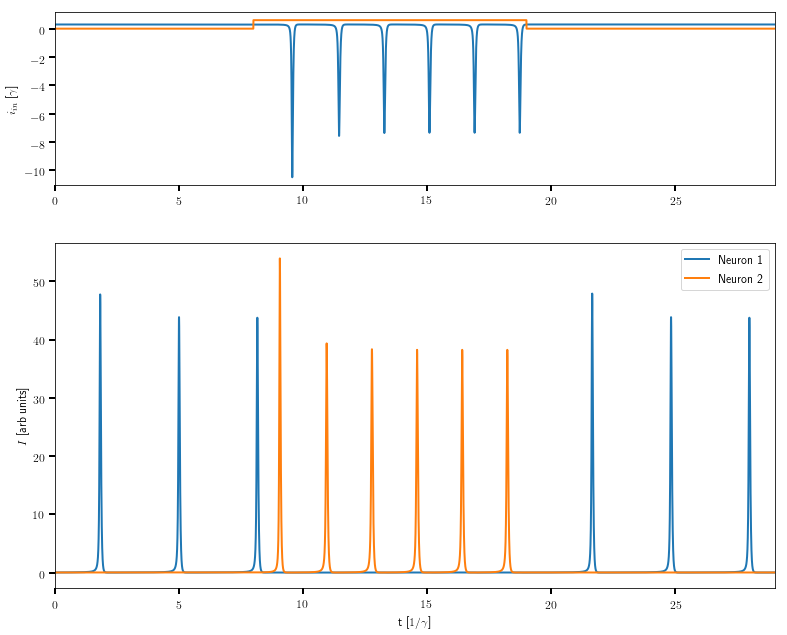

In [16]:
#use visualize_plot to generate a quick plot of the network dynamics
fig2=network2.visualize_plot(input2, output2, time2)
fig2.set_size_inches(10, 8, forward=True)

Below is a visualization of the same dynamics as an animated graph.  Each neuron is depicted as a node of the network which brightens when it fires.  The connectivity between network elements is also indicated.

''

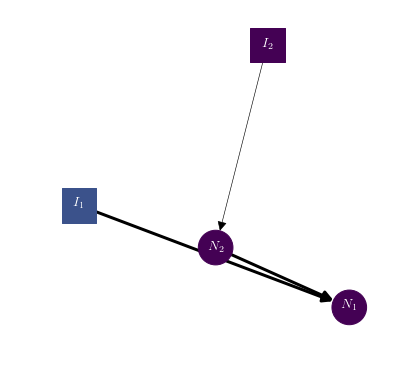

In [23]:
an2 = network2.visualize_animation(inputs=in2, outputs=output2);


In [22]:
HTML(an2.to_html5_video()) #note that this HTML call can be time-consuming